<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman Filters

## Kalman Filters from scratch

### 前準備

配色を定義。
詳細は [matplotlib - List of named colors](https://matplotlib.org/stable/gallery/color/named_colors.html#tableau-palette) を参照。

In [102]:
from matplotlib.colors import TABLEAU_COLORS

BLUE = TABLEAU_COLORS["tab:blue"]
ORANGE = TABLEAU_COLORS["tab:orange"]
GREEN = TABLEAU_COLORS["tab:green"]
RED = TABLEAU_COLORS["tab:red"]
PURPLE = TABLEAU_COLORS["tab:purple"]

アニメーション描画用の関数を定義

In [103]:
from matplotlib.patches import Ellipse

def create_anim(true_points, observations, kf_points, kf_errors, name="kf.gif"):
    # 描画設定
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)

    # 軌跡描画のレイヤー
    gt_traj_plt, = ax.plot([], [], c=BLUE, label="GT Trajectory")
    gt_pos_plt, = ax.plot(
        [], [], c=ORANGE, marker="o", markersize=5, label="True Point")
    obs_pos_scat = ax.scatter([], [], s=5, c=RED, label="Observation")
    kf_pos_plt, = ax.plot(
        [], [], c=GREEN, marker="o", markersize=5, label="Kalman Filter")

    # 観測誤差範囲
    obs_ellipse = Ellipse(
        xy=(0, 1), width=NOISE_SIGMA, height=NOISE_SIGMA, angle=0,
        color=RED, alpha=0.1, animated=True)
    ax.add_patch(obs_ellipse)

    # 推定誤差範囲
    kalman_ellipse = Ellipse(
        xy=(0, 1), width=NOISE_SIGMA, height=NOISE_SIGMA, angle=0,
        color=GREEN, alpha=0.3, animated=True)
    ax.add_patch(kalman_ellipse)

    ax.legend(loc="upper right", fontsize="x-small")

    def anim_callback(i):
        ax.set_title(f"Frame {i}")

        # 正解
        gt_traj_plt.set_data(true_points[:i+1, 0], true_points[:i+1, 1])
        gt_pos_plt.set_data(true_points[i, 0], true_points[i, 1])

        # 観測点
        obs_pos_scat.set_offsets(observations[:i+1, :])
        obs_ellipse.set_center(observations[i, :])

        # フィルタ点
        kf_pos_plt.set_data(kf_points[i, 0], kf_points[i, 1])

        # フィルタ誤差
        width, height, angle = cov2ellipse(kf_errors[:, :, i])
        kalman_ellipse.set_center([kf_points[i, 0], kf_points[i, 1]])
        kalman_ellipse.set_width(width)
        kalman_ellipse.set_height(height)
        kalman_ellipse.set_angle(angle)

    ani = animation.FuncAnimation(fig, anim_callback, frames=len(observations))
    ani.save(name, writer="pillow")

### 使用する運動モデル

円運動モデル
\begin{equation}
\begin{pmatrix}
x \\ y
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta \\
\sin\theta
\end{pmatrix}
\end{equation}

In [104]:
import numpy as np

DT = 2 * np.pi / 100

def create_points():
    t = np.arange(0, 2*np.pi, DT)
    x = np.sin(t)
    y = np.cos(t)
    points = np.vstack((x, y)).T
    return points

points = create_points()

軌跡のアニメーション作成

<ipython-input-105-8af73df2f3a8>:21: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cur_pos_plt.set_data(points[i, 0], points[i, 1])


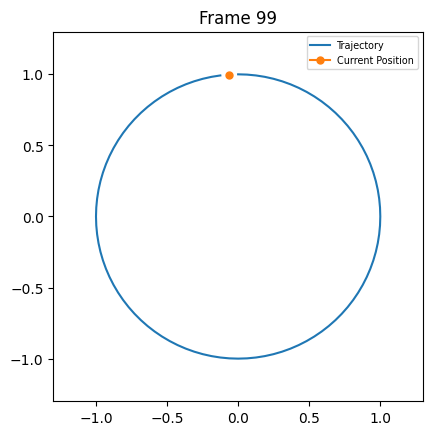

In [105]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def traj_anim(points):
    fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)

    traj_plt, = ax.plot([], [], c=BLUE, label="Trajectory")
    cur_pos_plt, = ax.plot(
        [], [], c=ORANGE, marker="o", markersize=5,
        label="Current Position")
    ax.legend(loc="upper right", fontsize="x-small")

    def anim_callback(i):
        ax.set_title(f"Frame {i}")
        traj_plt.set_data(points[:i, 0], points[:i, 1])
        cur_pos_plt.set_data(points[i, 0], points[i, 1])

    ani = animation.FuncAnimation(fig, anim_callback, frames=points.shape[0])
    ani.save("move.gif", writer="pillow")

traj_anim(points)

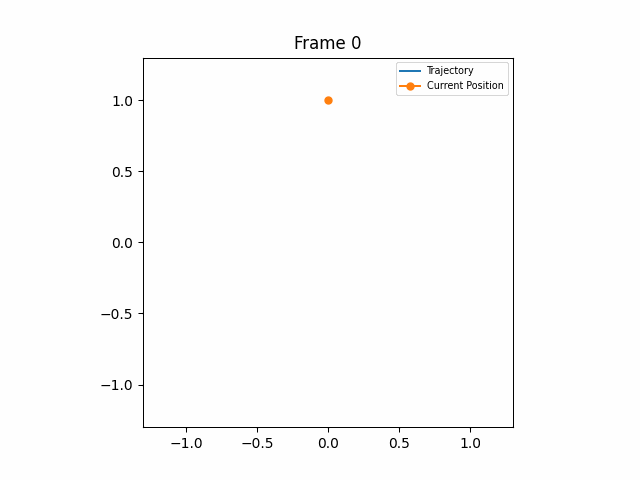

In [106]:
import IPython
from IPython.display import Image

# アニメーション再生
Image("./move.gif", format='png')

### EKF

EKF は非線形運動モデルを線形近似して Kalman Filter を適用するだけ。
Kalman Filter の公式は[ここ](https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%AB%E3%83%9E%E3%83%B3%E3%83%95%E3%82%A3%E3%83%AB%E3%82%BF%E3%83%BC)を参照。

今回の EKF での運動モデルの近似式は次の通り。
\begin{equation}
\begin{pmatrix}
x_{k+1} \\ y_{k+1}
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta_{k+1} \\ \sin\theta_{k+1}
\end{pmatrix}
=
\begin{pmatrix}
\cos(\theta_k+\delta\theta) \\ \sin(\theta_k+\delta\theta)
\end{pmatrix}
=
\begin{pmatrix}
1 & -\delta\theta \\
\delta\theta & 1
\end{pmatrix}
\begin{pmatrix}
x_k \\ y_k
\end{pmatrix}
+\frac{1}{2}
\begin{pmatrix}
 \cos\theta_0\delta\theta^2 \\
 \sin\theta_0\delta\theta^2
\end{pmatrix}
+\mathcal{O}(\delta\theta^3)
\end{equation}

誤差絶対値の上限値を用いて次の近似をする。
\begin{equation}
\begin{pmatrix}
x_{k+1} \\ y_{k+1}
\end{pmatrix}
\simeq
\begin{pmatrix}
1 & -\delta\theta \\
\delta\theta & 1
\end{pmatrix}
\begin{pmatrix}
x_k \\ y_k
\end{pmatrix}
+w_k,\quad
w_k\sim N\left(0,\frac{1}{2}\delta\theta^2I\right)
\end{equation}

観測モデルは$(x,y)$変数の多変量正規分布とする。
\begin{equation}
\begin{pmatrix}
x_k' \\ y_k'
\end{pmatrix}
=
\begin{pmatrix}
x_k \\ y_k
\end{pmatrix}
+ v_k,\quad
v_k\sim N(0,\sigma^2 I)
\end{equation}

差分化の刻み幅（FPS）は短いほど拡張カルマンフィルタの精度は良くなる。

In [107]:
from abc import ABC, abstractmethod

class Tracking(ABC):
    def __init__(
            self, state: np.ndarray, state_error: np.ndarray,
            pred_error: np.ndarray,obs_error: np.ndarray):
        self.state = state
        self.state_error = state_error
        self.pred_error = pred_error
        self.obs_error = obs_error

    @abstractmethod
    def predict(self):
        pass

    @abstractmethod
    def update(self, observation: np.ndarray):
        pass

In [108]:
NOISE_SIGMA = 0.4


class EKF(Tracking):
    def __init__(
            self, state: np.ndarray, state_error: np.ndarray,
            pred_mat: np.ndarray, pred_error: np.ndarray,
            obs_mat: np.ndarray, obs_error: np.ndarray):
        super().__init__(state, state_error, pred_error, obs_error)
        self.pred_mat = pred_mat
        self.obs_mat = obs_mat

    def predict(self):
        self.state = self.pred_mat @ self.state
        self.state_error = (
            self.pred_mat @ self.state_error @ self.pred_mat.T
            + self.pred_error
        )

    def update(self, observation: np.ndarray):
        # カルマンゲインを計算
        innovation = observation - self.obs_mat @ self.state
        innovation_cov = (
            self.obs_mat @ self.state_error @ self.obs_mat.T
            + self.obs_error
        )
        kalman_gain = (
            self.state_error @ self.obs_mat @ np.linalg.inv(innovation_cov)
        )

        # フィルタリング
        self.state = self.state + kalman_gain @ innovation
        self.state_error = (
            (np.eye(len(self.state)) - kalman_gain) @ self.state_error
        )

正規分布ノイズを与えて疑似観測データを作成

In [109]:
def create_obs(points):
    noise = np.random.normal(0, NOISE_SIGMA**2, (points.shape[0], 2))
    points_obs = points + noise
    return points_obs

points_obs = create_obs(points)

EKF 実行

In [110]:
def ekf_integrate(points_obs):
    # 初期状態作成
    init_state = points_obs[0, :]
    init_state_error =np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])

    # EKF モデル設定 (時計回り回転)
    pred_mat = np.array([[1, DT], [-DT, 1]])
    pred_error = np.array([[0.5*DT**2, 0], [0, 0.5*DT**2]])
    obs_mat = np.eye(2)
    obs_error = np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])

    # EKF インスタンス生成
    kf = EKF(state=init_state, state_error=init_state_error,
                     pred_mat=pred_mat, pred_error=pred_error,
                     obs_mat=obs_mat, obs_error=obs_error)

    # 初期化
    pred_states = [np.array([0, 1])]
    kf_states = [init_state]
    kf_state_errors = [init_state_error]

    # 逐次ステップ計算
    for i in range(0, points_obs.shape[0]-1):
        # フィルタなし予測
        pred_state = pred_states[-1] @ kf.pred_mat
        pred_states.append(pred_state)

        # カルマンフィルタ
        kf.predict()
        kf.update(points_obs[i+1, :])

        # データ保存
        kf_states.append(kf.state)
        kf_state_errors.append(kf.state_error)

    # np.ndarray に変換
    pred_states = np.vstack(pred_states)
    kf_states = np.vstack(kf_states)
    kf_state_errors = np.dstack(kf_state_errors)

    return kf_states, kf_state_errors

誤差共分散行列を楕円で表すためのヘルパー関数

In [111]:
def cov2ellipse(cov: np.ndarray):
    eig_val, eig_vec = np.linalg.eigh(cov)
    angle = np.arctan2(eig_vec[1, 0], eig_vec[0, 0])
    width = np.sqrt(eig_val[0])
    height = np.sqrt(eig_val[1])
    return width, height, angle

GT・予測データ・観測データ・フュージョン結果を誤差分布付きで描画

In [112]:
%%capture
create_anim(points, points_obs, *ekf_integrate(points_obs), name="ekf.gif")

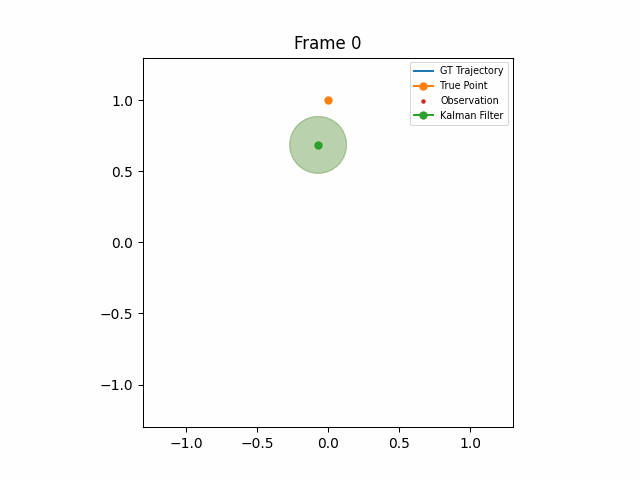

In [113]:
Image("./ekf.gif", format='png')

### UKF

https://inzkyk.xyz/kalman_filter/unscented_kalman_filter/#section:10.5

シグマ点
\begin{align}
&\vec{s}^0=\vec{\mu},\quad
w_m^0=\frac{\lambda}{n+\lambda},\quad
w_c^0=\frac{\lambda}{n+\lambda}+(1-\alpha^2+\beta), \\
&\vec{s}^i=\vec{\mu}+\sqrt{n+\lambda}\sqrt{\Sigma}_{\lceil i\rceil}, \quad
\vec{s}^{i+n}=\vec{\mu}-\sqrt{n+\lambda}\sqrt{\Sigma}_{\lceil i\rceil}, \\
&w_m^i=w_c^i=\frac{1}{2(n+\lambda)},\quad
i=1,2,\ldots,n\,\\
&\kappa\leq0,\quad\alpha\in[0,1],\quad
\lambda=\alpha^2(n+\kappa)-n,\quad\beta=2
\end{align}

In [149]:
from re import X
from typing import Callable
import numpy as np

class UKF(Tracking):
    def __init__(
            self, state: np.ndarray, state_error: np.ndarray,
            pred_map: Callable[[np.ndarray], np.ndarray], pred_error: np.ndarray,
            obs_map: Callable[[np.ndarray], np.ndarray], obs_error: np.ndarray,
            alpha: float=0.1, beta: float=2, kappa: float=-1):
        super().__init__(state, state_error, pred_error, obs_error)

        self.pred_map = pred_map
        self.obs_map = obs_map

        # パラメータ
        n = state.shape[0]
        self.lambda_ = alpha**2 * (n + kappa) - n

        # ウェイト
        self.w_m = np.full(2 * n + 1, 1 / (2 * (n + self.lambda_)))
        self.w_c = np.full(2 * n + 1, 1 / (2 * (n + self.lambda_)))
        self.w_m[0] = self.lambda_ / (n + self.lambda_)
        self.w_c[0] = self.lambda_ / (n + self.lambda_) + (1 - alpha**2 + beta)

        self.sigmas = self.get_sigmas()

    def predict(self):
        self.sigmas = self.get_sigmas()

        self.sigmas = np.array([
            self.pred_map(sigma) for sigma in self.sigmas])

        self.state, self.state_error = self.u_transform(
            self.sigmas, self.pred_error)

    def update(self, observation: np.ndarray):
        obs_sigmas = np.array([
            self.obs_map(sigma)
            for sigma in self.sigmas
        ])

        z_mu, z_error = self.u_transform(obs_sigmas, self.obs_error)

        xz_error = np.zeros((len(self.state), len(z_mu)))
        for idx in range(len(self.w_c)):
            xz_error += self.w_c[idx] * np.outer(
                self.sigmas[idx, :] - self.state, obs_sigmas[idx, :] - z_mu)

        # フィルタリング
        kalman_gain = xz_error @ np.linalg.inv(z_error)
        self.state = (
            self.state + kalman_gain @ (observation - z_mu)
        )
        self.state_error = (
            self.state_error - kalman_gain @ z_error @ kalman_gain.T
        )

    def u_transform(self, sigmas, noise_cov):
        mu = 0
        for idx in range(len(self.w_m)):
            mu += self.w_m[idx] * sigmas[idx, :]

        cov_mat = np.zeros_like(noise_cov)
        for idx in range(len(self.w_c)):
            cov_mat += self.w_c[idx] * np.outer(
                sigmas[idx, :] - mu, sigmas[idx, :] - mu)
        cov_mat += noise_cov

        return mu, cov_mat

    def get_sigmas(self):
        n = len(self.state)
        sqrt_mat = np.linalg.cholesky((n + self.lambda_) * self.state_error)

        sigma_plus = self.state + sqrt_mat
        sigma_minus = self.state - sqrt_mat
        sigmas = np.vstack((self.state, sigma_plus, sigma_minus))

        return sigmas

In [150]:
def ukf_integrate(points_obs):
    # 初期状態作成
    init_state = points_obs[0, :]
    init_state_error =np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])

    # UKF モデル設定
    pred_map = lambda x: np.array([
        [np.cos(DT), np.sin(DT)], [-np.sin(DT), np.cos(DT)]]) @ x
    # pred_error = np.array([[0.02, 0], [0, 0.02]])
    pred_error = np.array([[0.5*DT**2, 0], [0, 0.5*DT**2]])
    obs_map = lambda x: x
    obs_error = np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])

    # UKF インスタンス作成
    kf = UKF(state=init_state, state_error=init_state_error,
                     pred_map=pred_map, pred_error=pred_error,
                     obs_map=obs_map, obs_error=obs_error)

    # 予測状態・カルマンフィルタ後の状態を初期化
    pred_states = [np.array([0, 1])]
    pred_sigmas = [np.array([[0, 1]])]
    kf_states = [init_state]
    kf_errors = [init_state_error]

    # 逐次ステップ計算
    for i in range(0, points_obs.shape[0]-1):
        # フィルタなし予測
        pred_state = pred_map(pred_states[-1])
        pred_states.append(pred_state)

        # カルマンフィルタ
        kf.predict()
        kf.update(points_obs[i+1, :])
        pred_sigmas.append(np.array(kf.sigmas))
        kf_states.append(kf.state)
        kf_errors.append(kf.state_error)

    # np.ndarray に変換
    pred_states = np.vstack(pred_states)
    kf_states = np.vstack(kf_states)
    kf_errors = np.dstack(kf_errors)

    return kf_states, kf_errors

<ipython-input-103-95f3c883945c>:37: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  gt_pos_plt.set_data(true_points[i, 0], true_points[i, 1])
<ipython-input-103-95f3c883945c>:44: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  kf_pos_plt.set_data(kf_points[i, 0], kf_points[i, 1])


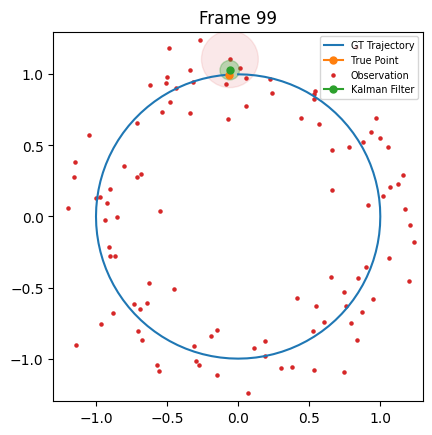

In [151]:
create_anim(points, points_obs, *ukf_integrate(points_obs), name="ukf.gif")

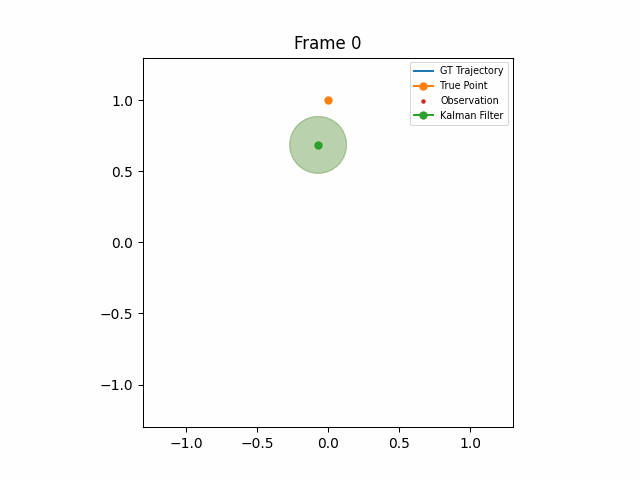

In [152]:
Image("./ukf.gif", format='png')

## Kalman Filter by FilterPy

[The Documentation](https://filterpy.readthedocs.io/en/latest/)

In [118]:
%%capture
!pip install filterpy

### UKF

[The API](https://filterpy.readthedocs.io/en/latest/kalman/UnscentedKalmanFilter.html)

In [119]:
from filterpy import kalman

def filterpy_integrate(points_obs):
    # UKF モデル作成
    pred_map = lambda x, dt: x @ np.array([
        [np.cos(dt), -np.sin(dt)], [np.sin(dt), np.cos(dt)]])
    obs_map = lambda x: x

    points = kalman.MerweScaledSigmaPoints(
        2, alpha=0.1, beta=2., kappa=-1)

    kf = kalman.UnscentedKalmanFilter(
        dim_x=2, dim_z=2, dt=DT, hx=obs_map, fx=pred_map, points=points)
    kf.x = points_obs[0, :]
    kf.P *= NOISE_SIGMA**2
    kf.R = np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])
    kf.Q = np.array([[0.5*DT**2, 0], [0, 0.5*DT**2]])
    # kf.Q = np.array([[0.02, 0], [0, 0.02]])

    # 逐次ステップ計算
    states = [kf.x]
    errors = [kf.P]
    for i in range(0, points_obs.shape[0]-1):
        # カルマンフィルタ
        kf.predict()
        kf.update(points_obs[i+1, :])
        states.append(kf.x)
        errors.append(kf.P)

    # np.ndarray に変換
    states = np.vstack(states)
    errors = np.dstack(errors)

    return states, errors

In [120]:
%%capture
create_anim(
    points, points_obs, *filterpy_integrate(points_obs), name="filterpy.gif")

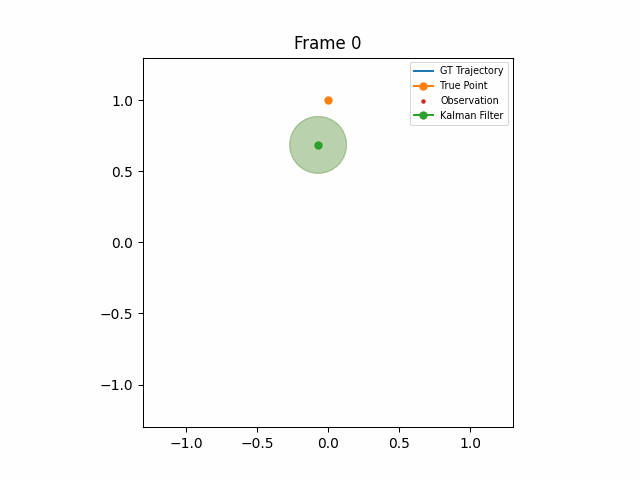

In [121]:
Image("./filterpy.gif", format='png')

## 二重振り子 by FilterPy

[二重振り子のラグランジアン](https://monologue-physics.hatenablog.com/entry/2021/09/22/155932)
\begin{align}
L&=\frac{m_1}{2}(\dot{x_1}^2+\dot{y_1}^2)+\frac{m_2}{2}(\dot{x_2}^2+\dot{y_2}^2)-m_1gy_1-m_2gy_2 \\
&=
\frac{1}{2}(m_1+m_2)l_1^2\dot{\theta_1}^2
+\frac{1}{2}m_2l_2^2\dot{\theta_2}^2
+m_2l_1l_2\dot{\theta_1}\dot{\theta_2}\cos(\theta_1-\theta_2)
+(m_1+m_2)gl_1\cos(\theta_1)+m_2gl_2\cos(\theta_2)
\end{align}

$\theta_1$ についてのラグランジュ方程式
\begin{equation}
(m_1+m_2)l_1^2\ddot{\theta_1}+(m_1+m_2)gl_1\sin(\theta_1)+m_2l_1l_2\left(\ddot{\theta_2}\cos(\theta_1-\theta_2)+\dot{\theta_2}^2\sin(\theta_1-\theta_2)\right)=0
\end{equation}

$\theta_2$ についてのラグランジュ方程式
\begin{equation}
m_2l_2^2\ddot{\theta_2}+m_2l_1l_2\left(\ddot{\theta_1}\cos(\theta_1-\theta_2)-\dot{\theta_1}^2\sin(\theta_1-\theta_2)\right)+m_2gl_2\sin(\theta_2)=0
\end{equation}

数値計算するには連立一次方程式である[正準方程式](https://www.aihara.co.jp/~taiji/pendula-equations/present-node2.html)の方が望ましい。

$\vec{\theta}\equiv(\theta_1, \theta_2)^T$ に対する正準方程式
\begin{equation}
\dot{\vec{\theta}}
=\frac{1}{(m_1+m_2)l_1^2m_2l_2^2-m_2^2l_1^2l_2^2\cos(\theta_1-\theta_2)}
\begin{pmatrix}
m_2l_2^2p_1-m_2l_1l_2\cos(\theta_1-\theta_2)p_2 \\
-m_2l_1l_2\cos(\theta_1-\theta_2)+(m_1+m_2)l_1^2p_2
\end{pmatrix}
\end{equation}

$\vec{p}\equiv(p_1,p_2)^T$に対する正準方程式
\begin{equation}
\dot{\vec{p}}=
\begin{pmatrix}
-m_2l_1l_2\sin(\theta_1-\theta_2)\dot{\theta_1}\dot{\theta_2}-(m_1+m_2)gl_1\sin(\theta_1) \\
m_2l_1l_2\sin(\theta_1-\theta_2)\dot{\theta_1}\dot{\theta_2}-m_2gl_2\sin(\theta_2) \\
\end{pmatrix}
\end{equation}

簡便のため $m_1=m_2=l_1=l_2=1$ として次を得る。
\begin{align}
&\dot{\vec{\theta}}
=\frac{1}{2-\cos(\theta_1-\theta_2)}
\begin{pmatrix}
p_1-\cos(\theta_1-\theta_2)p_2 \\
-\cos(\theta_1-\theta_2)+2p_2
\end{pmatrix} \\
&\dot{\vec{p}}=
\begin{pmatrix}
-\sin(\theta_1-\theta_2)\dot{\theta_1}\dot{\theta_2}-2g\sin(\theta_1) \\
\sin(\theta_1-\theta_2)\dot{\theta_1}\dot{\theta_2}-g\sin(\theta_2) \\
\end{pmatrix}
\end{align}

In [153]:
def dp_fmap(x: np.ndarray, dt: float):
    theta1, theta2, p1, p2 = x
    cos = np.cos(theta1 - theta2)
    sin = np.sin(theta1 - theta2)

    d_theta1 = (p1 - cos * p2) / (2-cos)
    d_theta2 = -cos + 2 * p2 / (2-cos)

    g = 9.8
    d_p1 = -sin * d_theta1 * d_theta2 - 2 * g * sin(theta1)
    d_p2 = sin * d_theta1 * d_theta2 - g * sin(theta2)

    theta1_next = theta1 + d_theta1 * dt
    theta2_next = theta2 + d_theta2 * dt
    p1_next = p1 + d_p1 * dt
    p2_next = p2 + d_p2 * dt

    return np.array([theta1_next, theta2_next, p1_next, p2_next])

def dp_hmap(x: np.ndarray):
    theta1, theta2, p1, p2 = x

    x1 = np.sin(theta1)
    y1 = -np.cos(theta1)
    x2 = x1 + np.sin(theta2)
    y2 = y1 - np.cos(theta2)

    return np.array([x1, y1, x2, y2])